In [1]:
##%pip install --upgrade pip

%pip install lightweight_mmm==0.1.7
%pip install immutabledict
%pip install numpyro
%pip install pandas
%pip install scikit-learn
%pip install statsmodels
%pip install tensorflow==2.7.2
%pip install jax jaxlib==0.4.2


  Using cached lightweight_mmm-0.1.7-py3-none-any.whl (103 kB)
  Using cached jax-0.4.6-py3-none-any.whl
ERROR: Could not find a version that satisfies the requirement tensorflow>=2.7.2 (from lightweight-mmm) (from versions: none)
ERROR: No matching distribution found for tensorflow>=2.7.2
Note: you may need to restart the kernel to use updated packages.
  Using cached immutabledict-2.2.3-py3-none-any.whl (4.0 kB)
Note: you may need to restart the kernel to use updated packages.
  Using cached numpyro-0.11.0-py3-none-any.whl (300 kB)
  Using cached multipledispatch-0.6.0-py3-none-any.whl (11 kB)
  Using cached numpy-1.24.2-cp310-cp310-macosx_11_0_arm64.whl (13.9 MB)
  Using cached jaxlib-0.4.6-cp310-cp310-macosx_11_0_arm64.whl (53.2 MB)
  Using cached jax-0.4.6-py3-none-any.whl
  Using cached scipy-1.10.1-cp310-cp310-macosx_12_0_arm64.whl (28.8 MB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
Note: you may need to restart the kernel to use updated packages.
  Using cached p

In [1]:
import pandas as pd


import jax.numpy as jnp
import numpyro as np

RuntimeError: jaxlib is version 0.4.2, but this version of jax requires version >= 0.4.4.

In [1]:
#Import the relevant modules of the library
from lightweight_mmm import lightweight_mmm
from lightweight_mmm import optimize_media
from lightweight_mmm import plot
from lightweight_mmm import preprocessing
from lightweight_mmm import utils

RuntimeError: This version of jaxlib was built using AVX instructions, which your CPU and/or operating system do not support. You may be able work around this issue by building jaxlib from source.

In [5]:
from sklearn.metrics import mean_absolute_percentage_error

#Read the data
##%pip install openpyxl
data = pd.read_excel('~/Downloads/mmm_data_clean_5.xlsx', sheet_name='mmm', header=0, index_col=0, keep_default_na=True)



In [6]:
#Group data and create variables
agg_data = data.groupby(["date","channel"])[["impressions","spend", "conversions",]].sum()


#Create data variables and remove zeros
media_data_raw = agg_data['impressions'].unstack().fillna(0)
costs_raw = agg_data['spend'].unstack()
sales_raw = agg_data['conversions'].groupby("date").sum()

print(media_data_raw)

channel     acquisition_other   apple  fb_prospecting_on  fb_prospecting_show  \
date                                                                            
2021-01-01             598530   60923            3482523               976030   
2021-01-02             761297   51507            3403410               798985   
2021-01-03             678038   40848            4087272               847934   
2021-01-04             570207   31585            4144285               808242   
2021-01-05             634261   24570            3248295               562217   
...                       ...     ...                ...                  ...   
2023-02-24            7271341  165651             912179              1155161   
2023-02-25            9588998  225487             839075              1139282   
2023-02-26            9617258  225451             857587              1080460   
2023-02-27            8006365  122862             861409              1097287   
2023-02-28            687623

<ipython-input-7-ec55a25fb4e2>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr =(data.corr())


<Axes: >

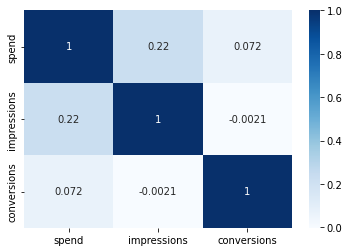

In [7]:
##Check data quality
##%pip install seaborn
import seaborn as sb
corr =(data.corr())
sb.heatmap(corr, cmap="Blues", annot=True)

In [8]:
##Splitting data intoi train and test

split_point = pd.Timestamp("2023-01-01") # 28 days to end of data

media_data_train = media_data_raw.loc[:split_point - pd.Timedelta(1,'D')]
media_data_test = media_data_raw.loc[split_point:]

target_train = sales_raw.loc[:split_point - pd.Timedelta(1,'D')]
target_test = sales_raw.loc[split_point:]

costs_train = costs_raw.loc[:split_point - pd.Timedelta(1,'D')].sum(axis=0).loc[media_data_train.columns]

In [9]:
#Check data
print(media_data_train)
print(costs_train)
print(target_train)

channel     acquisition_other   apple  fb_prospecting_on  fb_prospecting_show  \
date                                                                            
2021-01-01             598530   60923            3482523               976030   
2021-01-02             761297   51507            3403410               798985   
2021-01-03             678038   40848            4087272               847934   
2021-01-04             570207   31585            4144285               808242   
2021-01-05             634261   24570            3248295               562217   
...                       ...     ...                ...                  ...   
2022-12-27           21004434  182480             443985              1145605   
2022-12-28           24860217  166066             385454               980874   
2022-12-29           24418894  155099             433129              1039710   
2022-12-30           24914605  163837             398809              1011416   
2022-12-31           2375407

In [10]:
##Create simulated organic traffic as extra feature. 
#Using organic data as extra features can give you a more accurate view of paid media effects.

import numpy as np
organic_raw = pd.DataFrame({'organic_search': 0, 'organic_social': 0}, index=media_data_raw.index)
organic_raw['organic_search'] = sales_raw.values/10 + np.random.randint(10000, 100000, organic_raw.shape[0])
organic_raw['organic_social'] = sales_raw.values/10 + np.random.randint(10000, 100000, organic_raw.shape[0])
print(organic_raw)

            organic_search  organic_social
date                                      
2021-01-01         35164.2         47630.2
2021-01-02         41169.1         25040.1
2021-01-03         43204.9         41636.9
2021-01-04         49140.5        100746.5
2021-01-05         51572.4        103191.4
...                    ...             ...
2023-02-24         60457.6         55825.6
2023-02-25         83850.6         55683.6
2023-02-26         29569.1         28426.1
2023-02-27         96051.1         88359.1
2023-02-28         32852.9         21368.9

[789 rows x 2 columns]


In [11]:
##Scaling data
split_point = pd.Timestamp("2023-02-01") # 28 days to end of data

media_data_train = media_data_raw.loc[:split_point - pd.Timedelta(1,'D')]
media_data_test = media_data_raw.loc[split_point:]

organic_data_train = organic_raw.loc[:split_point - pd.Timedelta(1,'D')]
organic_data_test = organic_raw.loc[split_point:]

target_train = sales_raw.loc[:split_point - pd.Timedelta(1,'D')]
target_test = sales_raw.loc[split_point:]

costs_train = costs_raw.loc[:split_point - pd.Timedelta(1,'D')].sum(axis=0).loc[media_data_train.columns]

media_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
organic_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
target_scaler = preprocessing.CustomScaler(
    divide_operation=jnp.mean)
cost_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)

media_data_train_scaled = media_scaler.fit_transform(media_data_train.values)
organic_data_train_scaled = organic_scaler.fit_transform(organic_data_train.values)
target_train_scaled = target_scaler.fit_transform(target_train.values.squeeze())
costs_scaled = cost_scaler.fit_transform(costs_train.values)

media_data_test_scaled = media_scaler.transform(media_data_test.values)
organic_data_test_scaled = organic_scaler.transform(organic_data_test.values)

media_names = media_data_raw.columns
TF_CPP_MIN_LOG_LEVEL=0

NameError: name 'preprocessing' is not defined

In [ ]:
##Finding the right hyper-parameters

adstock_models = ["adstock", "hill_adstock", "carryover"]
degrees_season = [1,2,3]

##Narrowing down hyper params
adstock_models = ["hill_adstock"]
degrees_season = [1]

##A simple loop was added to do a tiny grid search to find the best value
#for two parameters: the adstock transformation and degrees of seasonality. 
#We can ad all models but model will run significantly slower.

for model_name in adstock_models: 
    for degrees in degrees_season:
        mmm = lightweight_mmm.LightweightMMM(model_name=model_name)
        mmm.fit(
            media=media_data_train_scaled,
            media_prior=costs_scaled,
            target=target_train_scaled,
            extra_features=organic_data_train_scaled,
            number_warmup=1000,
            number_samples=1000,
            number_chains=1,
            degrees_seasonality=degrees,
            weekday_seasonality=True,
            seasonality_frequency=365,
            seed=1)
    
    prediction = mmm.predict(
    media=media_data_test_scaled,
    extra_features=organic_data_test_scaled,
    target_scaler=target_scaler)
    p = prediction.mean(axis=0)

    mape = mean_absolute_percentage_error(target_test.values, p)
    print(f"model_name={model_name} degrees={degrees} MAPE={mape} samples={p[:3]}")

In [ ]:
##Model diagnostics Convergence Check
mmm.print_summary()
##Fitting check
plot.plot_model_fit(media_mix_model=mmm, target_scaler=target_scaler)
#Predictive check
prediction = mmm.predict(
    media=media_data_test,
    #extra_features=organic_data_test[-1:, :],
    target_scaler=target_scaler
)


In [ ]:
#Retraining LightweightMMM --using all data not sampled
costs = costs_raw.sum(axis=0).loc[media_names]

media_scaler2 = preprocessing.CustomScaler(divide_operation=jnp.mean)
organic_scaler2 = preprocessing.CustomScaler(divide_operation=jnp.mean)
target_scaler2 = preprocessing.CustomScaler(
    divide_operation=jnp.mean)
cost_scaler2 = preprocessing.CustomScaler(divide_operation=jnp.mean)

media_data_scaled = media_scaler2.fit_transform(media_data_raw.values)
organic_data_scaled = organic_scaler2.fit_transform(organic_raw.values)
target_scaled = target_scaler2.fit_transform(sales_raw.values)
costs_scaled2 = cost_scaler2.fit_transform(costs.values)

media_names = media_data_raw.columns

mmm = lightweight_mmm.LightweightMMM(model_name="hill_adstock")
mmm.fit(media=media_data_scaled,
        media_prior=costs_scaled2,
        extra_features=organic_data_scaled,
        target=target_scaled,
        number_warmup=1000,
        number_samples=1000,
        number_chains=1,
        degrees_seasonality=1,
        weekday_seasonality=True,
        seasonality_frequency=365,
        seed=1)

In [ ]:
#Parameter estimate check

plot.plot_media_channel_posteriors(media_mix_model=mmm, channel_names=media_names)

In [ ]:
##Response curve check
plot.plot_response_curves(media_mix_model=mmm, media_scaler=media_scaler, target_scaler=target_scaler)

In [ ]:
media_effect_hat, roi_hat = mmm.get_posterior_metrics()

In [ ]:
#Check ROI
plot.plot_bars_media_metrics(metric=roi_hat, channel_names=media_names)

In [ ]:
##Run budget optimizer
prices = costs/media_data_raw.sum(axis=0)
budget = 100 # your budget here
solution = optimize_media.find_optimal_budgets(
    n_time_periods=5,
    media_mix_model=mmm,
    extra_features=organic_data_scaled[-5:, :],
    budget=budget,
    prices=prices.values)

In [ ]:
##Save the model
utils.save_model(mmm, file_path='file_path')

In [ ]:
##Load model
utils.load_model(file_path: 'file_path')